In [35]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel')}

def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Faster R-CNN demo')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default=0, type=int)
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16]',
                        choices=NETS.keys(), default='vgg16')

    args = parser.parse_args()

    return args

cfg.TEST.HAS_RPN = True  # Use RPN for proposals                                                                                      
prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

# Initialize caffe
timer = Timer()
timer.tic()
caffe.set_mode_cpu()
net = caffe.Net(prototxt, caffemodel, caffe.TEST)
timer.toc()
print '\n\nLoaded network {:s}, {:.3f}s'.format(caffemodel, timer.total_time)



Loaded network /workspace/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel, 0.677s


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/004545.jpg
Detection took 16.804s for 300 object proposals


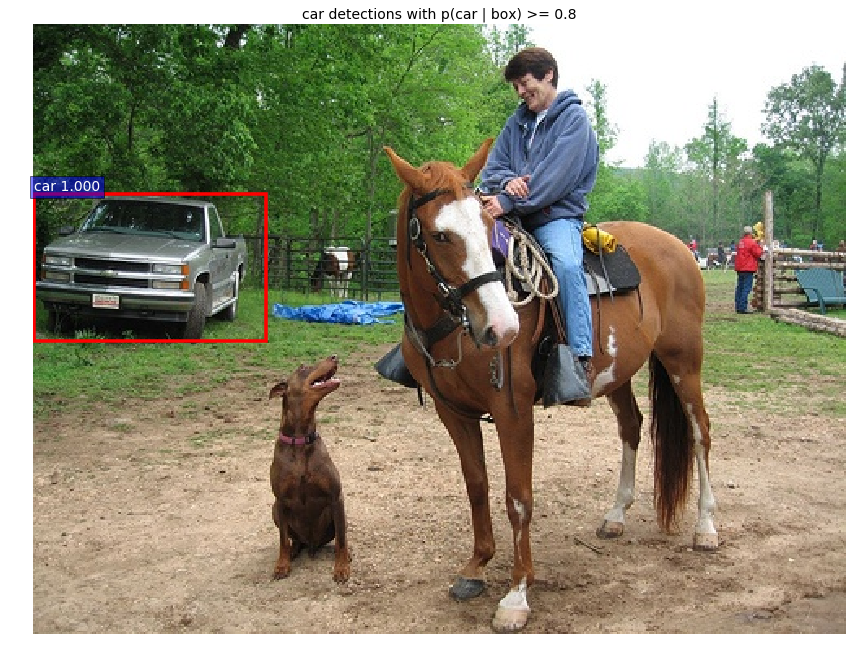

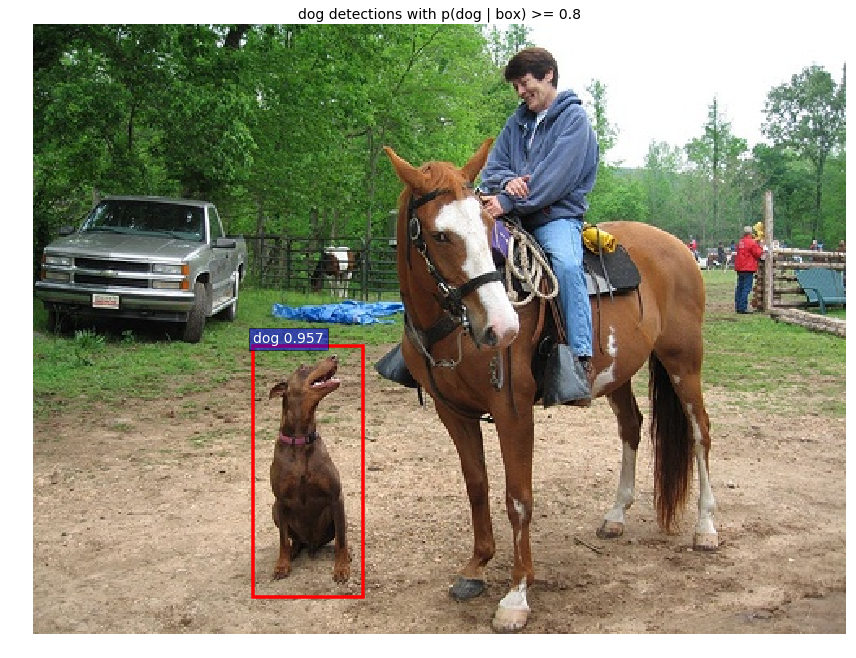

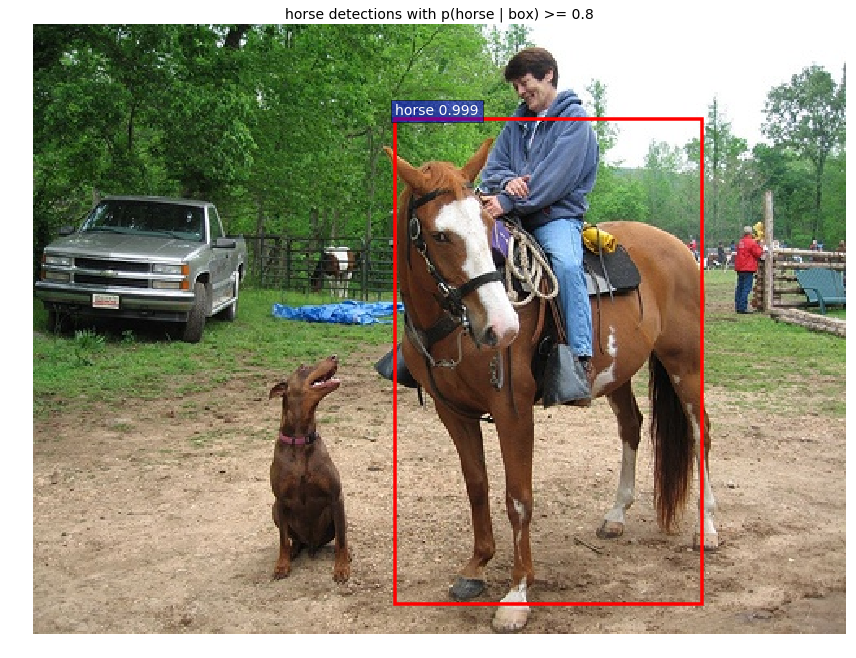

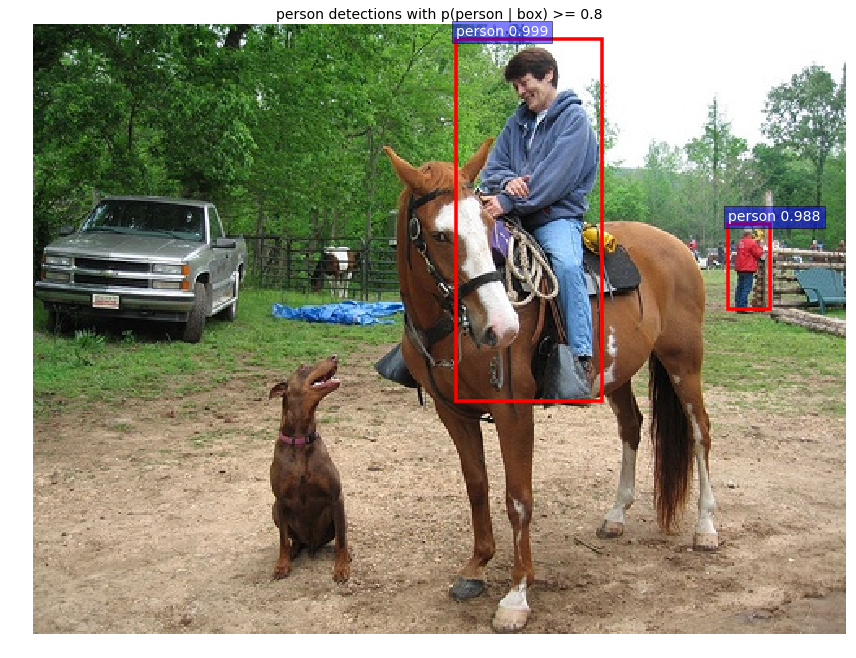

In [40]:



def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

    
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image                                                                                                                 
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)
    
#     im = im[:, :, (2, 1, 0)]
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.imshow(im, aspect='equal')
#     rect = plt.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
#     plt.show()
#     plt.draw()    

    # Detect all object classes and regress object bounds                                                                                 
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class                                                                                                 
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background                                                                                      
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

# Warmup on a dummy image                                                                                                             
# im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
# for i in xrange(2):
#     _, _= im_detect(net, im)

import os, cv2
import _init_paths
from fast_rcnn.config import cfg
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle

im_names = ['004545.jpg']#, '000456.jpg', '000542.jpg', '001150.jpg',
#              '001763.jpg']
for im_name in im_names:
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Demo for data/demo/{}'.format(im_name)
    demo(net, im_name)    
plt.show()